<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="4">Otimização de Hiperparâmetros em Modelos de Deep Learning Para a Capacidade</font></b></strong>

Criamos alguns modelos de Deep Learning até aqui para prever nossa série temporal, mas não tivemos resultados realmente diferenciados. A vida como ela é na prática. Não espere mágica, isso não existe. O que existe é conhecimento e trabalho duro, assim que conquistamos resultados. 

Os modelos de Deep Learning não tem alcançado boa performance por uma razão simples: nosso conjunto de dados é pequeno. Deep Learning mostra seu brilho quando temos um volume de dados realmente grande (aquele tal de Big Data).

Poderíamos, claro, trabalhar com a nossa série de vendas diárias e assim teríamos um volume de dados muito maior. Mas ao decidir trabalhar com a série da média mensal, precisaríamos de um volume de dados pelo menos 10x maior. Isso fica evidente pelos resultados similares em quase todos os modelos que criamos até aqui (com ou sem Deep Learning). Trabalhar com séries mensais é sempre um grande desafio e pode não ser a melhor opção.

E por que trabalhamos com a média mensal e não as vendas diárias? Porque nosso objetivo neste curso era mostrar não apenas ferramentas e análise, mas as dificuldades inerentes ao processo, quando uma série é difícil de ajustar ou o volume de dados é pequeno. Dependendo do problema podemos não alcançar um resultado satisfatório. É assim que as coisas funcionam na vida real.

**Mas vamos para mais uma tentativa. O trabalho em Data Science passa por experimentação e podemos experimentar outras abordagens e comparar os resultados.**

Como diria Rocky Balboa: "Mais um round, por favor!"

Nesta aula vamos aplicar uma mudança na preparação dos dados e criar um modelo LSTM Bidirectional (uma das arquiteturas de Deep Learning mais avançadas quando trabalhamos com séries usando modelos LSTM) e depois aplicar Grid Search para otimizar os hiperparâmetros do modelo e criar a versão final.

Já posso antecipar: será a melhor versão dos modelos de Deep Learning que criamos até aqui.

Resumindo o que faremos nesta aula:
    
- Removeremos os picos de vendas da série original.
- Criaremos a primeira versão do modelo LSTM Bidirectional.
- Executaremos o Grid Search para buscar os melhores hiperparâmetros.
- Criaremos a versão final do modelo com os melhores hiperparâmetros.

Esta aula considera que você já tem alguma noção sobre o que é Deep Learning e a definição de Deep Learning.

Esse conhecimento pode ser obtido no material gratuito fornecido pela DSA, o <a href="http://www.deeplearningbook.com.br/">Deep Learning Book</a>. Lá você encontra alguns capítulos inteiros dedicados às LSTMs. Recomendamos a leitura antes de prosseguir nesta aula.

A execução do Jupyter Notebook desta aula vai levar um bom tempo, pois está "pesadão". Seja paciente!

Se estiver com um tempo de sobra, depois experimente o pacote xarray, que otimiza o trabalho com séries temporais em Python (de fato otimiza o trabalho com diversas estruturas de dados): http://xarray.pydata.org/en/v0.15.1/time-series.html

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import math
import numpy as np
import pandas as pd
import itertools
from pandas import Series
from pandas.tseries.offsets import DateOffset

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports para modelagem preditiva
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
#matplotlib.style.use('ggplot')
#%matplotlib inline

from time import time

In [2]:
# Imports para modelagem preditiva - Tensorflow 1.
#import keras
#from keras.preprocessing.sequence import TimeseriesGenerator
#from keras.models import Sequential
#from keras.layers.core import Dense, Activation
#from keras.layers import LSTM
#from keras.layers import Dropout

In [3]:
# Imports para modelagem preditiva - Tensorflow 2.0
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
print(tf.__version__)

2.0.0


In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

pandas                1.0.5
seaborn               0.10.1
sklearn               0.23.1
statsmodels           0.11.1
tensorflow            2.0.0
statsmodels.api       0.11.1
matplotlib            3.3.0
numpy                 1.16.6
tensorflow_core.keras 2.2.4-tf
Data Science Academy


## Definição do Problema de Negócio

Previsão de arrecadação de ICMS.

## Conjunto de Dados

Usaremos conjuntos de dados que mostram a arrecadação de ICMS. Os dados tem registros dos anos de 2010 a 2015.

Será fornecido 1 dataset com 2 colunas, data e arrecadação de icms. 

In [5]:
# Carrega os dados
dataframe = pd.read_csv("Arrecadacao_icms.csv")
dataframe['Data'] = pd.to_datetime(dataframe.Data, format = '%d/%m/%Y')
dataframe = dataframe.set_index('Data')

In [6]:
# Dados
dataframe.head()

,Arrecadacao
Data,
2010-01-01,3299311
2010-02-01,2415158
2010-03-01,2613292
2010-04-01,2533679
2010-05-01,2426702


In [7]:
# Refinamos os dados para o gráfico da série original
# A variável File_System é nossa variável target 
target = dataframe['Arrecadacao']

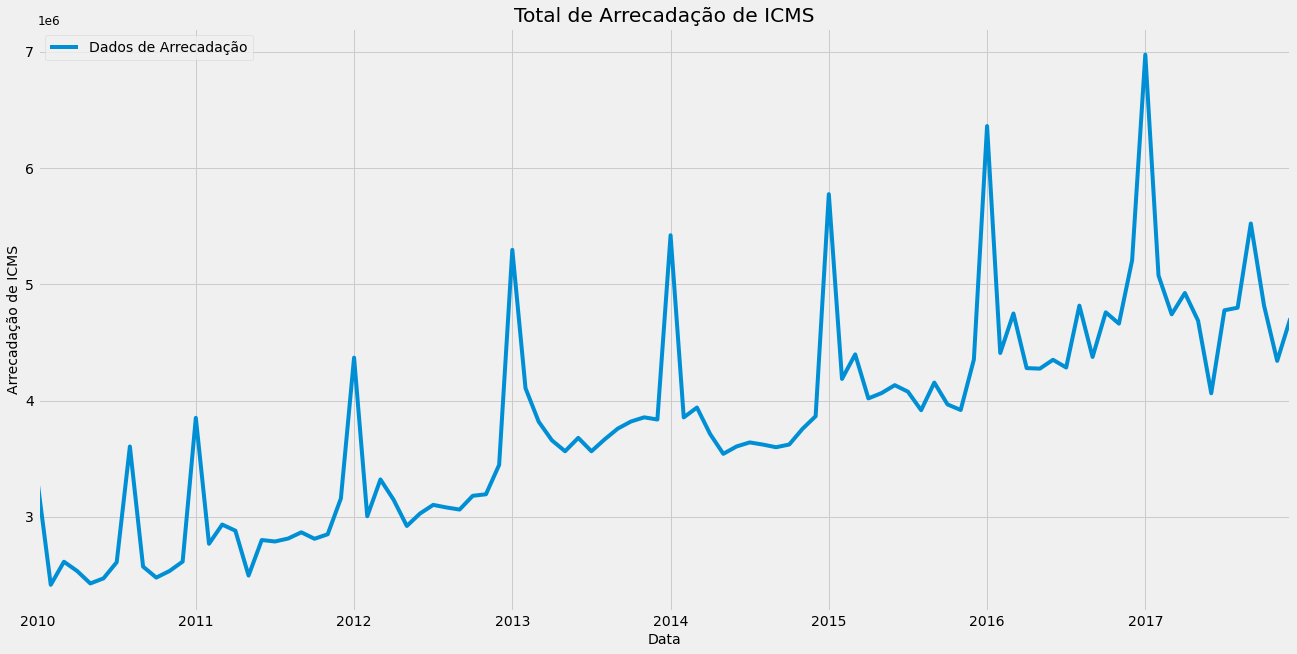

In [8]:
# Plot
target.plot(title = 'Total de Arrecadação de ICMS', fontsize = 14, label = 'Dados de Arrecadação') 
plt.xlabel("Data") 
plt.ylabel("Arrecadação de ICMS") 
plt.legend(loc = 'best') 
plt.show()

In [9]:
# Divisão em treino e teste
treino_size = int(len(target) * 0.75)
treino, teste = target[0:treino_size], target[treino_size:]
print(len(treino), len(teste))

72 24


Para a preparação dos dados, vamos alternar entre objetos NumPy e Pandas, usando o que cada um oferece de melhor.

In [10]:
# Ajusta o shape, pois agora não temos um objeto pd.Series, 
# mas sim um array NumPy, que é necessário para treinar o modelo LSTM
trainset = treino.values.reshape(-1,1)
testset = teste.values.reshape(-1,1)

In [11]:
# Função
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 4))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 4))+
                  '\nMAPE das previsões é {}'.format(round(mape, 4))))

## Modelo LSTM Bidirectional

Redes LSTMs Bidirecionais são uma extensão das LSTMs tradicionais que podem melhorar o desempenho do modelo preditivo.

Nos problemas em que todos os timesteps da sequência de entrada estão disponíveis, redes LSTMs Bidirecionais treinam duas em vez de uma rede LSTM na sequência de entrada. A primeira na sequência de entrada original e a segunda em uma cópia invertida da sequência de entrada. Isso pode fornecer um contexto adicional à rede e resultar em um aprendizado mais rápido e ainda mais completo sobre o problema.

As redes neurais recorrentes bidirecionais estão realmente apenas juntando duas RNNs independentes. A sequência de entrada é alimentada em ordem de tempo normal para uma rede e em ordem inversa para outra. As saídas das duas redes são geralmente concatenadas a cada etapa do tempo, embora existam outras opções.

Esse modelo é estudado em detalhes no curso <a href="https://www.datascienceacademy.com.br/course?courseid=deep-learning-ii">Deep Learning II</a>.

### Preparando os Dados Para Treinamento

Como regra geral, sempre que você usa uma rede neural, você deve normalizar ou dimensionar seus dados. Usaremos a classe MinMaxScaler da biblioteca sklearn.preprocessing para dimensionar nossos dados entre 0 e 1. O parâmetro feature_range é usado para especificar o intervalo dos dados dimensionados e se não for especificado o intevalo será entre 0 e 1.

In [12]:
# Cria o scaler
scaler = MinMaxScaler()

In [13]:
# Treina o scaler nos dados de treino (nunca no dataset completo ou nos dados de teste)
scaler.fit(trainset)

MinMaxScaler()

In [14]:
# Aplica o mesmo scaler aos dados de treino 
# (Não precisamos aplicar aos dados de teste, pois vamos converter a saída das previsões antes de avaliar o modelo)
trainset = scaler.transform(trainset)

Aqui definimos os hiperparâmetros, os mesmos que usamos anteriormente em outros modelos LSTM que criamos.

In [15]:
# Número de repetições
n_rep = 20

# Número de epochs
num_epochs = 200

# Número de inputs (usaremos 24 séries para prever as 24 séries seguintes)
n_input = 24

# Comprimento das sequências de saída (em número de timesteps)
n_output = 24

# Aqui estamos indicando que nossa série é univariada, logo, apenas 1 recurso
n_features = 1

# Número de amostras de séries temporais em cada lote
size_batch = 10

O TimeseriesGenerator do Keras transforma automaticamente um conjunto de dados univariado de séries temporais em um dataset para problema de aprendizado supervisionado.

https://keras.io/preprocessing/sequence/

In [16]:
# Generator
generator = TimeseriesGenerator(trainset, 
                                trainset, 
                                length = n_output,
                                batch_size = size_batch)

Podemos agora criar o modelo.

Para começar a aplicação de Deep Learning ao nosso problema criaremos um modelo básico de LSTM que chamarei de LSTM Padrão.

Aqui está a principal diferença dos modelos de Deep Learning para outros métodos de previsão de séries temporais. Temos que criar o modelo com cada camada da rede neural.

Como trabalharemos com batches de dados da série que serão passados pela rede várias vezes, vamos criar o modelo e gerar os batches de dados a cada passada de um loop. As camadas de rede nada mais são que operações matemáticas.

Nas próximas aulas ensinarei a você como definir os parâmetros da rede (como número de neurônios e dropout). Por agora, leia os comentários em cada linha de código abaixo.

In [17]:
# Criação e treinamento do modelo LSTM Padrão
start = time()

# Criamos uma matriz preenchida com zeros que receberá o resultado das previsões do nosso modelo
resultado = np.zeros((n_input, n_rep))

# Loop
# Vamos repetir o processo de treinamento por 20 vezes e armazenar todos os resultados, pois assim usaremos
# diferentes amostras. Ao final, tiramos a média para encontrar as previsões.
for i in range(n_rep):
    
    # O primeiro passo é criar o modelo, ou seja, um objeto da classe Sequential() do Keras
    modelo_lstm = Sequential()
    
    # Modelo Bidirectional
    modelo_lstm.add(Bidirectional(LSTM(48, activation = 'relu'), input_shape = (24, 1)))
    modelo_lstm.add(Dense(1))
    
    # Com as camadas prontas, podemos definir a função de perda, nesse caso usaremos o MSE (Mean Squared Error)
    # E indicamos o algoritmo de otimização (minimização da função de perda), em nosso caso ADAM
    modelo_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    # Aqui fazemos o treinamento gerando batches de dados
    modelo_lstm.fit_generator(generator, epochs = num_epochs)
    
    # Lista para as previsões
    pred_list = []

    # Gera um batch de dados
    batch = trainset[-n_input:].reshape((1, n_input, n_features))

    # Loop para fazer as previsões
    for j in range(n_input):   
        pred_list.append(modelo_lstm.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:], [[pred_list[j]]], axis = 1)

    # Gera o dataframe com as previsões
    df_predict_modelo_lstm = pd.DataFrame(scaler.inverse_transform(pred_list),
                                      index = target[-n_input:].index, columns = ['Prediction'])

    resultado[:,i] = df_predict_modelo_lstm['Prediction']
    
print(resultado)

print ('\nTempo gasto: %s segundos' % str(time() - start))

Epoch 1/200
5/5 [==============================] - 1s 224ms/step - loss: 0.1379
Epoch 2/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0887
Epoch 3/200
5/5 [==============================] - 1s 172ms/step - loss: 0.0456
Epoch 4/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0274
Epoch 5/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0264
Epoch 6/200
5/5 [==============================] - 1s 167ms/step - loss: 0.0262
Epoch 7/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0238
Epoch 8/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0227
Epoch 9/200
5/5 [==============================] - 1s 185ms/step - loss: 0.0229
Epoch 10/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0222
Epoch 11/200
5/5 [==============================] - 1s 172ms/step - loss: 0.0215
Epoch 12/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0216
Epoch 13/200
5/5 [===================

5/5 [==============================] - 1s 170ms/step - loss: 0.1673
Epoch 3/200
5/5 [==============================] - 1s 169ms/step - loss: 0.1241
Epoch 4/200
5/5 [==============================] - 1s 167ms/step - loss: 0.0880
Epoch 5/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0538
Epoch 6/200
5/5 [==============================] - 1s 168ms/step - loss: 0.0315
Epoch 7/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0259
Epoch 8/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0263
Epoch 9/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0227
Epoch 10/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0226
Epoch 11/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0227
Epoch 12/200
5/5 [==============================] - 1s 168ms/step - loss: 0.0224
Epoch 13/200
5/5 [==============================] - 1s 168ms/step - loss: 0.0221
Epoch 14/200
5/5 [==============================

5/5 [==============================] - 1s 170ms/step - loss: 0.0884
Epoch 4/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0513
Epoch 5/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0275
Epoch 6/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0244
Epoch 7/200
5/5 [==============================] - 1s 167ms/step - loss: 0.0287
Epoch 8/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0238
Epoch 9/200
5/5 [==============================] - 1s 168ms/step - loss: 0.0219
Epoch 10/200
5/5 [==============================] - 1s 168ms/step - loss: 0.0225
Epoch 11/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0223
Epoch 12/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0219
Epoch 13/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0216
Epoch 14/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0217
Epoch 15/200
5/5 [=============================

5/5 [==============================] - 1s 169ms/step - loss: 0.0278
Epoch 5/200
5/5 [==============================] - 1s 168ms/step - loss: 0.0236
Epoch 6/200
5/5 [==============================] - 1s 168ms/step - loss: 0.0275
Epoch 7/200
5/5 [==============================] - 1s 168ms/step - loss: 0.0210
Epoch 8/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0220
Epoch 9/200
5/5 [==============================] - 1s 168ms/step - loss: 0.0223
Epoch 10/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0217
Epoch 11/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0215
Epoch 12/200
5/5 [==============================] - 1s 193ms/step - loss: 0.0213
Epoch 13/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0210
Epoch 14/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0209
Epoch 15/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0209
Epoch 16/200
5/5 [============================

5/5 [==============================] - 1s 169ms/step - loss: 0.0420
Epoch 6/200
5/5 [==============================] - 1s 168ms/step - loss: 0.0244
Epoch 7/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0319
Epoch 8/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0233
Epoch 9/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0220
Epoch 10/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0228
Epoch 11/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0219
Epoch 12/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0214
Epoch 13/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0218
Epoch 14/200
5/5 [==============================] - 1s 174ms/step - loss: 0.0216
Epoch 15/200
5/5 [==============================] - 1s 168ms/step - loss: 0.0213
Epoch 16/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0211
Epoch 17/200
5/5 [===========================

5/5 [==============================] - 1s 172ms/step - loss: 0.0266
Epoch 7/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0257
Epoch 8/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0228
Epoch 9/200
5/5 [==============================] - 1s 168ms/step - loss: 0.0225
Epoch 10/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0229
Epoch 11/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0226
Epoch 12/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0221
Epoch 13/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0219
Epoch 14/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0218
Epoch 15/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0217
Epoch 16/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0216
Epoch 17/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0215
Epoch 18/200
5/5 [==========================

5/5 [==============================] - 1s 172ms/step - loss: 0.0179
Epoch 108/200
5/5 [==============================] - 1s 172ms/step - loss: 0.0179
Epoch 109/200
5/5 [==============================] - 1s 172ms/step - loss: 0.0178
Epoch 110/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0177
Epoch 111/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0177
Epoch 112/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0176
Epoch 113/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0176
Epoch 114/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0175
Epoch 115/200
5/5 [==============================] - 1s 173ms/step - loss: 0.0176
Epoch 116/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0173
Epoch 117/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0173
Epoch 118/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0173
Epoch 119/200
5/5 [===========

5/5 [==============================] - 1s 171ms/step - loss: 0.0121
Epoch 109/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0108
Epoch 110/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0099
Epoch 111/200
5/5 [==============================] - 1s 168ms/step - loss: 0.0082
Epoch 112/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0073
Epoch 113/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0057
Epoch 114/200
5/5 [==============================] - 1s 173ms/step - loss: 0.0116
Epoch 115/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0115
Epoch 116/200
5/5 [==============================] - 1s 167ms/step - loss: 0.0088
Epoch 117/200
5/5 [==============================] - 1s 168ms/step - loss: 0.0098
Epoch 118/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0094
Epoch 119/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0094
Epoch 120/200
5/5 [===========

5/5 [==============================] - 1s 177ms/step - loss: 0.0234
Epoch 9/200
5/5 [==============================] - 1s 185ms/step - loss: 0.0222
Epoch 10/200
5/5 [==============================] - 1s 173ms/step - loss: 0.0228
Epoch 11/200
5/5 [==============================] - 1s 178ms/step - loss: 0.0225
Epoch 12/200
5/5 [==============================] - 1s 177ms/step - loss: 0.0222
Epoch 13/200
5/5 [==============================] - 1s 173ms/step - loss: 0.0219
Epoch 14/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0220
Epoch 15/200
5/5 [==============================] - 1s 174ms/step - loss: 0.0218
Epoch 16/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0217
Epoch 17/200
5/5 [==============================] - 1s 175ms/step - loss: 0.0217
Epoch 18/200
5/5 [==============================] - 1s 177ms/step - loss: 0.0216
Epoch 19/200
5/5 [==============================] - 1s 172ms/step - loss: 0.0214
Epoch 20/200
5/5 [========================

5/5 [==============================] - 1s 169ms/step - loss: 0.0239
Epoch 10/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0237
Epoch 11/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0225
Epoch 12/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0221
Epoch 13/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0224
Epoch 14/200
5/5 [==============================] - 1s 168ms/step - loss: 0.0224
Epoch 15/200
5/5 [==============================] - 1s 168ms/step - loss: 0.0221
Epoch 16/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0221
Epoch 17/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0220
Epoch 18/200
5/5 [==============================] - 1s 203ms/step - loss: 0.0221
Epoch 19/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0220
Epoch 20/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0218
Epoch 21/200
5/5 [=======================

5/5 [==============================] - 1s 169ms/step - loss: 0.0233
Epoch 11/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0221
Epoch 12/200
5/5 [==============================] - 1s 172ms/step - loss: 0.0220
Epoch 13/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0220
Epoch 14/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0219
Epoch 15/200
5/5 [==============================] - 1s 172ms/step - loss: 0.0219
Epoch 16/200
5/5 [==============================] - 1s 172ms/step - loss: 0.0220
Epoch 17/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0217
Epoch 18/200
5/5 [==============================] - 1s 172ms/step - loss: 0.0218
Epoch 19/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0216
Epoch 20/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0216
Epoch 21/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0218
Epoch 22/200
5/5 [=======================

5/5 [==============================] - 1s 185ms/step - loss: 0.0143
Epoch 112/200
5/5 [==============================] - 1s 173ms/step - loss: 0.0113
Epoch 113/200
5/5 [==============================] - 1s 176ms/step - loss: 0.0138
Epoch 114/200
5/5 [==============================] - 1s 177ms/step - loss: 0.0121
Epoch 115/200
5/5 [==============================] - 1s 174ms/step - loss: 0.0107
Epoch 116/200
5/5 [==============================] - 1s 174ms/step - loss: 0.0093
Epoch 117/200
5/5 [==============================] - 1s 178ms/step - loss: 0.0092
Epoch 118/200
5/5 [==============================] - 1s 181ms/step - loss: 0.0082
Epoch 119/200
5/5 [==============================] - 1s 182ms/step - loss: 0.0082
Epoch 120/200
5/5 [==============================] - 1s 173ms/step - loss: 0.0103
Epoch 121/200
5/5 [==============================] - 1s 176ms/step - loss: 0.0127
Epoch 122/200
5/5 [==============================] - 1s 176ms/step - loss: 0.0092
Epoch 123/200
5/5 [===========

5/5 [==============================] - 1s 176ms/step - loss: 0.0218
Epoch 12/200
5/5 [==============================] - 1s 177ms/step - loss: 0.0216
Epoch 13/200
5/5 [==============================] - 1s 172ms/step - loss: 0.0221
Epoch 14/200
5/5 [==============================] - 1s 173ms/step - loss: 0.0217
Epoch 15/200
5/5 [==============================] - 1s 178ms/step - loss: 0.0214
Epoch 16/200
5/5 [==============================] - 1s 181ms/step - loss: 0.0219
Epoch 17/200
5/5 [==============================] - 1s 172ms/step - loss: 0.0216
Epoch 18/200
5/5 [==============================] - 1s 175ms/step - loss: 0.0215
Epoch 19/200
5/5 [==============================] - 1s 176ms/step - loss: 0.0214
Epoch 20/200
5/5 [==============================] - 1s 178ms/step - loss: 0.0215
Epoch 21/200
5/5 [==============================] - 1s 176ms/step - loss: 0.0212
Epoch 22/200
5/5 [==============================] - 1s 176ms/step - loss: 0.0216
Epoch 23/200
5/5 [=======================

5/5 [==============================] - 1s 172ms/step - loss: 0.0070
Epoch 113/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0070
Epoch 114/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0072
Epoch 115/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0097
Epoch 116/200
5/5 [==============================] - 1s 173ms/step - loss: 0.0089
Epoch 117/200
5/5 [==============================] - 1s 172ms/step - loss: 0.0081
Epoch 118/200
5/5 [==============================] - 1s 168ms/step - loss: 0.0078
Epoch 119/200
5/5 [==============================] - 1s 173ms/step - loss: 0.0071
Epoch 120/200
5/5 [==============================] - 1s 175ms/step - loss: 0.0070
Epoch 121/200
5/5 [==============================] - 1s 173ms/step - loss: 0.0065
Epoch 122/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0068
Epoch 123/200
5/5 [==============================] - 1s 172ms/step - loss: 0.0075
Epoch 124/200
5/5 [===========

5/5 [==============================] - 1s 180ms/step - loss: 0.0091
Epoch 114/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0078
Epoch 115/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0085
Epoch 116/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0078
Epoch 117/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0087
Epoch 118/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0098
Epoch 119/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0094
Epoch 120/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0091
Epoch 121/200
5/5 [==============================] - 1s 173ms/step - loss: 0.0088
Epoch 122/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0080
Epoch 123/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0077
Epoch 124/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0082
Epoch 125/200
5/5 [===========

5/5 [==============================] - 1s 171ms/step - loss: 0.0052
Epoch 115/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0059
Epoch 116/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0058
Epoch 117/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0067
Epoch 118/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0058
Epoch 119/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0073
Epoch 120/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0054
Epoch 121/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0055
Epoch 122/200
5/5 [==============================] - 1s 173ms/step - loss: 0.0051
Epoch 123/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0052
Epoch 124/200
5/5 [==============================] - 1s 172ms/step - loss: 0.0048
Epoch 125/200
5/5 [==============================] - 1s 211ms/step - loss: 0.0048
Epoch 126/200
5/5 [===========

5/5 [==============================] - 1s 171ms/step - loss: 0.0142
Epoch 116/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0138
Epoch 117/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0136
Epoch 118/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0132
Epoch 119/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0130
Epoch 120/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0125
Epoch 121/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0118
Epoch 122/200
5/5 [==============================] - 1s 174ms/step - loss: 0.0118
Epoch 123/200
5/5 [==============================] - 1s 172ms/step - loss: 0.0111
Epoch 124/200
5/5 [==============================] - 1s 172ms/step - loss: 0.0109
Epoch 125/200
5/5 [==============================] - 1s 174ms/step - loss: 0.0106
Epoch 126/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0103
Epoch 127/200
5/5 [===========

5/5 [==============================] - 1s 171ms/step - loss: 0.0181
Epoch 117/200
5/5 [==============================] - 1s 172ms/step - loss: 0.0182
Epoch 118/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0179
Epoch 119/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0179
Epoch 120/200
5/5 [==============================] - 1s 172ms/step - loss: 0.0179
Epoch 121/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0178
Epoch 122/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0178
Epoch 123/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0177
Epoch 124/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0177
Epoch 125/200
5/5 [==============================] - 1s 172ms/step - loss: 0.0178
Epoch 126/200
5/5 [==============================] - 1s 178ms/step - loss: 0.0181
Epoch 127/200
5/5 [==============================] - 1s 173ms/step - loss: 0.0175
Epoch 128/200
5/5 [===========

5/5 [==============================] - 1s 171ms/step - loss: 0.0227
Epoch 17/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0226
Epoch 18/200
5/5 [==============================] - 1s 173ms/step - loss: 0.0224
Epoch 19/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0226
Epoch 20/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0225
Epoch 21/200
5/5 [==============================] - 1s 173ms/step - loss: 0.0223
Epoch 22/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0223
Epoch 23/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0223
Epoch 24/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0222
Epoch 25/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0221
Epoch 26/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0222
Epoch 27/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0220
Epoch 28/200
5/5 [=======================

5/5 [==============================] - 1s 171ms/step - loss: 0.0216
Epoch 17/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0214
Epoch 18/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0216
Epoch 19/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0215
Epoch 20/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0212
Epoch 21/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0211
Epoch 22/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0212
Epoch 23/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0211
Epoch 24/200
5/5 [==============================] - 1s 172ms/step - loss: 0.0212
Epoch 25/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0209
Epoch 26/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0210
Epoch 27/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0208
Epoch 28/200
5/5 [=======================

5/5 [==============================] - 1s 170ms/step - loss: 0.0094
Epoch 118/200
5/5 [==============================] - 1s 172ms/step - loss: 0.0081
Epoch 119/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0080
Epoch 120/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0073
Epoch 121/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0072
Epoch 122/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0074
Epoch 123/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0074
Epoch 124/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0071
Epoch 125/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0081
Epoch 126/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0082
Epoch 127/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0068
Epoch 128/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0079
Epoch 129/200
5/5 [===========

5/5 [==============================] - 1s 170ms/step - loss: 0.0113
Epoch 119/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0162
Epoch 120/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0141
Epoch 121/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0104
Epoch 122/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0101
Epoch 123/200
5/5 [==============================] - 1s 168ms/step - loss: 0.0103
Epoch 124/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0096
Epoch 125/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0095
Epoch 126/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0091
Epoch 127/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0082
Epoch 128/200
5/5 [==============================] - 1s 168ms/step - loss: 0.0086
Epoch 129/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0079
Epoch 130/200
5/5 [===========

5/5 [==============================] - 1s 169ms/step - loss: 0.0052
Epoch 120/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0063
Epoch 121/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0053
Epoch 122/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0049
Epoch 123/200
5/5 [==============================] - 1s 226ms/step - loss: 0.0050
Epoch 124/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0051
Epoch 125/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0052
Epoch 126/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0069
Epoch 127/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0059
Epoch 128/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0063
Epoch 129/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0061
Epoch 130/200
5/5 [==============================] - 1s 172ms/step - loss: 0.0074
Epoch 131/200
5/5 [===========

5/5 [==============================] - 1s 175ms/step - loss: 0.0065
Epoch 121/200
5/5 [==============================] - 1s 186ms/step - loss: 0.0073
Epoch 122/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0061
Epoch 123/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0077
Epoch 124/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0075
Epoch 125/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0076
Epoch 126/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0137
Epoch 127/200
5/5 [==============================] - 1s 169ms/step - loss: 0.0183
Epoch 128/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0125
Epoch 129/200
5/5 [==============================] - 1s 170ms/step - loss: 0.0129
Epoch 130/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0149
Epoch 131/200
5/5 [==============================] - 1s 171ms/step - loss: 0.0128
Epoch 132/200
5/5 [===========

Agora calculamos o erro modelo.

In [18]:
# Vamos criar uma matriz com as mesmas dimensões da matriz de resultado usada no treinamento
resultado_final = np.zeros((resultado.shape[0],1))

In [19]:
# Loop para gerar as previsões finais
for i in range(resultado.shape[0]):
    resultado_final[i] = np.mean(resultado[i,:])

In [20]:
# Ajustamos o shape
resultado_final = resultado_final.reshape((24,))

In [21]:
# Previsões finais
resultado_final

array([5792845.03803666, 4325538.88151559, 4355509.07579069,
       4105223.44841515, 3899704.87166964, 3910650.6850934 ,
       3898411.57762333, 3834176.49490314, 3767227.94859641,
       3757863.91140334, 3894191.80231867, 4087813.16212904,
       5957796.84633495, 4447952.11750301, 4613758.52949315,
       4235156.21372468, 4247776.82872155, 4288191.8271461 ,
       4208175.36026908, 4023414.48536106, 4205780.60471946,
       4015836.43662589, 3988056.15993097, 4465681.66748513])

In [22]:
testseta = testset.reshape((24,))
testseta

array([6360023, 4408531, 4748431, 4278694, 4273985, 4350053, 4283739,
       4816248, 4374269, 4758541, 4661014, 5206376, 6974641, 5075192,
       4741150, 4924371, 4686747, 4062240, 4775886, 4798030, 5522158,
       4817980, 4340612, 4706995], dtype=int64)

In [23]:
res = np.zeros((resultado.shape[0],1))
for i in range(resultado.shape[0]):
    res[i] = resultado_final[i] - testset[i]
    print('test =  %.4f  resultado = %.4f   Erro = %.4f' % (testset[i], resultado_final[i], res[i]))

test =  6360023.0000  resultado = 5792845.0380   Erro = -567177.9620
test =  4408531.0000  resultado = 4325538.8815   Erro = -82992.1185
test =  4748431.0000  resultado = 4355509.0758   Erro = -392921.9242
test =  4278694.0000  resultado = 4105223.4484   Erro = -173470.5516
test =  4273985.0000  resultado = 3899704.8717   Erro = -374280.1283
test =  4350053.0000  resultado = 3910650.6851   Erro = -439402.3149
test =  4283739.0000  resultado = 3898411.5776   Erro = -385327.4224
test =  4816248.0000  resultado = 3834176.4949   Erro = -982071.5051
test =  4374269.0000  resultado = 3767227.9486   Erro = -607041.0514
test =  4758541.0000  resultado = 3757863.9114   Erro = -1000677.0886
test =  4661014.0000  resultado = 3894191.8023   Erro = -766822.1977
test =  5206376.0000  resultado = 4087813.1621   Erro = -1118562.8379
test =  6974641.0000  resultado = 5957796.8463   Erro = -1016844.1537
test =  5075192.0000  resultado = 4447952.1175   Erro = -627239.8825
test =  4741150.0000  resultado 

In [24]:
# Calculamos e imprimos a performance do modelo
modelo_lstm_performance = performance(testset, resultado_final)
modelo_lstm_performance

MSE das previsões é 1028913561238.2358
RMSE das previsões é 1014353.7653
MAPE das previsões é 15.0767


Hummm....O resultado não foi muito bom! 

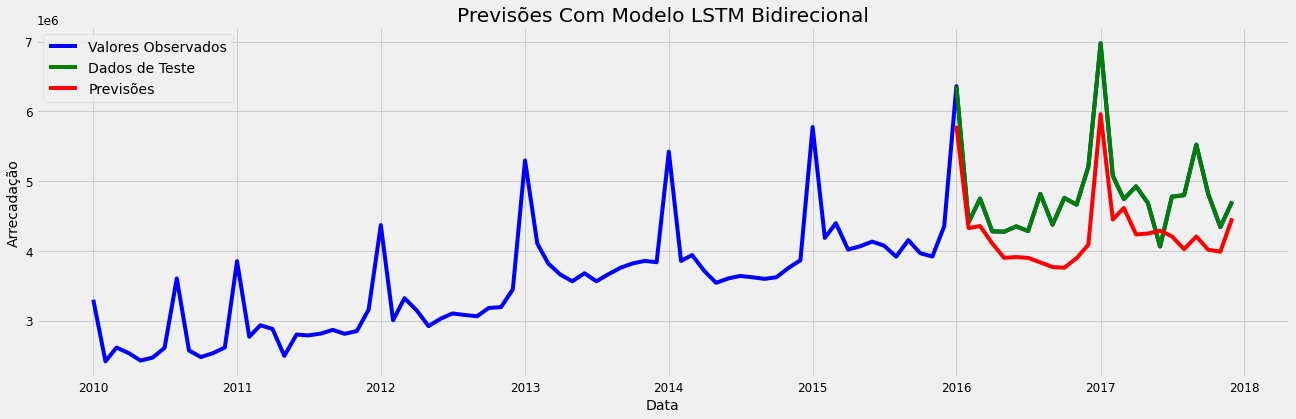

In [25]:
# Plot
plt.figure(figsize = (20, 6))

# Série original
plt.plot(target.index, target.values, label = 'Valores Observados', color = 'Blue')
plt.plot(teste, label = 'Dados de Teste', color = 'green')

# Previsões
plt.plot(target[72:].index, resultado_final, label = 'Previsões', color = 'Red')

plt.title('Previsões Com Modelo LSTM Bidirecional')
plt.xlabel('Data')
plt.ylabel('Arrecadação')
plt.legend(loc = 'upper left')
plt.show()

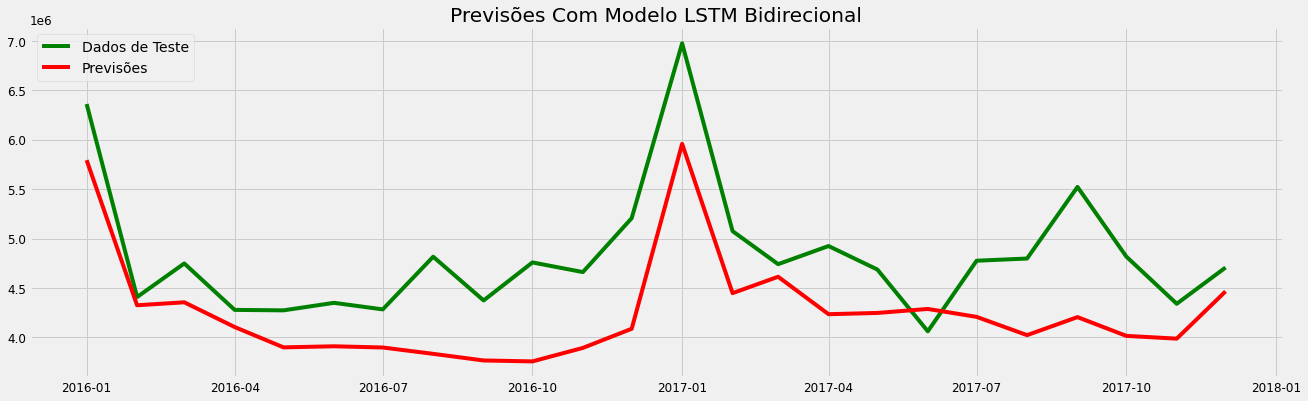

In [27]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(target[72:].index, resultado_final, label = 'Previsões', color = 'Red')
plt.title('Previsões Com Modelo LSTM Bidirecional')
plt.legend(loc = 'upper left')
plt.show()

Vamos fazer o Forecasting para 41 dias de horizonte de previsão. A função DateOffset() vai nos ajudar a criar as datas.

Vejamos qual é a última data da nossa série original:

In [28]:
# Última data da série
target.index[-1]

Timestamp('2017-12-01 00:00:00')

In [29]:
# Cria sequência de datas a partir da última data da nossa série original
datas_para_prever_forecasting = [target.index[-1] + DateOffset(months = x) for x in range(0, 25)]

In [30]:
# Visualiza as datas criadas
#datas_para_prever_forecasting

In [31]:
# Nossa série original é um objeto do tipo pd.Series
#type(arrecadacao_icms)

In [32]:
# Objetos do tipo pd.Series dão mais trabalho para manipular. Vamos converter a série original em dataframe.
df_original = pd.DataFrame(target)

In [33]:
# Visualiza os dados
#df_original.head()

In [34]:
# Vamos agora criar um novo dataframe 
# O índice (data) será a sequência de datas futuras
# O nome da coluna de dados extraímos da série original
# ATENÇÃO: Não estamos extraindo os dados da série original, somente o nome da coluna
data_futuras = pd.DataFrame(index = datas_para_prever_forecasting[1:], columns = df_original.columns)

In [35]:
# Visualiza os dados
# Entendeu por que os valores NaN? São datas futuras, e precisamos agora incluir nossas previsões.
#data_futuras

In [36]:
# Usamos as datas futuras para extrair as previsões do nosso modelo
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index = data_futuras[-n_input:].index, columns = ['Prediction'])

In [37]:
# Concatenamos a série original com os valores de forecasting de 41 dias além da série
df_forecasting = pd.concat([df_original, df_predict], axis = 1)

In [38]:
# Visualiza o dataframe
df_forecasting

,Arrecadacao,Prediction
2010-01-01,3299311.0,NaN
2010-02-01,2415158.0,NaN
2010-03-01,2613292.0,NaN
2010-04-01,2533679.0,NaN
2010-05-01,2426702.0,NaN
...,...,...
2019-08-01,NaN,3.910508e+06
2019-09-01,NaN,4.145011e+06
2019-10-01,NaN,3.928599e+06
2019-11-01,NaN,3.879522e+06


### Previsão x Forecasting

Esse dataframe acima é para não restar qualquer dúvida do que estamos fazendo.

Nas **previsões** do modelo, usamos os dados de teste, 24 meses que correspondem aos 24 últimos registros da série original (2017-01-01 a 2017-12-01. Fazemos isso para poder calcular a precisão do modelo, comparando as previsões com os valores reais. Esse é o padrão em Machine Learning.

No **forecasting**, criamos 24 meses após a última data da série original. Obviamente, não temos dados históricos para esses meses e o que queremos é exatamente a previsão de vendas. O forecasting significa usar o modelo treinado e prever valores sobre novas datas.

Bingo!

Vamos colocar o forecasting em um Plot.

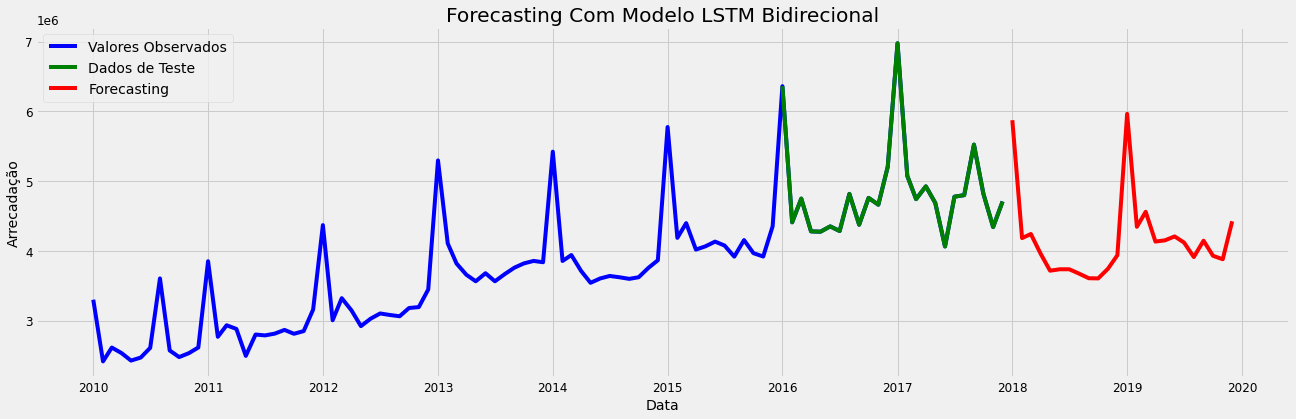

In [40]:
# Plot
plt.figure(figsize = (20, 6))

# Série original
plt.plot(target.index, target.values, label = 'Valores Observados', color = 'Blue')
plt.plot(teste, label = 'Dados de Teste', color = 'green')

# Previsões
plt.plot(df_forecasting.index, df_forecasting['Prediction'], label = 'Forecasting', color = 'Red')

plt.title('Forecasting Com Modelo LSTM Bidirecional')
plt.xlabel('Data')
plt.ylabel('Arrecadação')
plt.legend(loc = 'upper left')
plt.show()

Por que a linha vermelha do forecast é quase uma linha reta? Porque nosso modelo fez o que pedimos a ele. Aprendeu sobre as previsões das médias mensais de vendas. O maior problema nesse caso é que não capturamos os valores altos e baixos, mas somente a média. Por isso trabalhar com séries mensais é muito complicado e o ideal é mesmo usar séries diárias, como usaremos nas aulas finais do curso.

Mas não acabou. Vamos tentar otimizar os hiperparâmetros.

## Grid Search

Grid Search é o processo de executar o ajuste de hiperparâmetros para determinar os valores ideais para um modelo. Isso é significativo, pois o desempenho de todo o modelo é baseado nos valores de hiperparâmetros especificados.

Se você trabalha com Machine Learning, sabe como é um difícil estipular valores para hiperparâmetros. Encontrar a combinação ideal é muito complicado e o Grid Search é uma forma de automatizar o processo.

Vamos criar algumas funções e então testar diversas combinações de hiperpaâmetros. Leia os comentários para compreender o que está sendo feito em cada etapa.

**Tratando a Série Como um Dataset de Aprendizagem Supervisionada**

Precisamos ser capazes de enquadrar a série univariada de observações como um problema de aprendizado supervisionado, para que possamos usar Grid Search.

Um enquadramento de aprendizado supervisionado de uma série significa que os dados precisam ser divididos em vários exemplos com os quais o modelo aprende e generaliza.

Cada amostra deve ter um componente de entrada e um componente de saída.

O componente de entrada será um número de observações anteriores, como três anos ou 36 etapas de tempo.

O componente de saída será o total de vendas no próximo mês, porque estamos interessados em desenvolver um modelo para fazer previsões em uma etapa.

Podemos implementar isso usando a função shift() no DataFrame do pandas. Isso nos permite deslocar uma coluna para baixo (para frente no tempo) ou para trás (para trás no tempo). Podemos tomar a série como uma coluna de dados e, em seguida, criar várias cópias da coluna, avançar ou retroceder no tempo, a fim de criar as amostras com os elementos de entrada e saída necessários.

Quando uma série é alterada para baixo, os valores de NaN são introduzidos porque não temos valores além do início da série e então valores NaN devem ser removidos.

In [41]:
# Transforma a série em formato para aprendizagem supervisionada com dados de entrada e saída
# Como temos uma série temporal, o que fazemos é pegar um pasos no tempo da série 
# (por exemplo a venda média de Janeiro) e chamar de x e o próximo passo de tempo (venda média de Fevereiro) 
# chamamos de y. E fazemos isso em toda a série, por isso o shift (deslocamento) no código abaixo.

def transforma_serie(dados, num_input = 1, num_output = 1):
    
    # Converte os dados em formato dataframe do Pandas
    df = pd.DataFrame(dados)
    
    # Lista de colunas
    cols = list()
    
    # Loop para definir os dados de entrada
    for i in range(num_input, 0, -1):
        cols.append(df.shift(i))
        
    # Loop para definir os dados de saída    
    for i in range(0, num_output):
        cols.append(df.shift(-i))
    
    # Concatena entrada e saída em um único dataframe
    dataset_final = pd.concat(cols, axis = 1)
    
    # Remove valores NA
    dataset_final.dropna(inplace = True)
    
    return dataset_final.values

A função abaixo aplica a diferenciação à série, conforme o que estudamos em outras aulas e conforme o que for passado como parâmetro de ordem.

In [42]:
# Função para diferenciação do dataset
def difference(data, order):
    return [data[i] - data[i - order] for i in range(order, len(data))]

A função abaixo divide os dados de treino em treino e validação.

In [43]:
# Separa os dados de treino em treino e validação
def divide_treino_valid(dados, num):
    return dados[:-num], dados[-num:]

A próxima função será usada para treinar o modelo com as diferentes combinações de hiperparâmetros.

In [44]:
# Função para treinar o modelo
def treina_modelo(train, config):
    
    # Hiperparâmetros para o modelo
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    
    # Checa se devemos aplicar a diferenciação
    if n_diff > 0:
        train = difference(train, n_diff)
    
    # Transforma a série em formato de aprendizagem supervisionada
    data = transforma_serie(train, num_input = n_input)
    
    # Separa x e y
    train_x, train_y = data[:, :-1], data[:, -1]
    
    # Reshape dos dados para o formato [samples, timesteps, features]
    n_features = 1
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
    
    # Define o modelo
    model = Sequential()
    model.add(Bidirectional(LSTM(n_nodes, activation = 'relu', input_shape = (n_input, n_features))))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss = 'mse')
    
    # Treinamento
    model.fit(train_x, train_y, epochs = n_epochs, batch_size = n_batch, verbose = 0)
    
    return model

Se temos função ara treinar o modelo precisamos de uma para fazer as previsões com o modelo treinado. É o que temos abaixo.

In [45]:
# Função para as previsões do modelo
def previsao_serie(model, history, config):
    
    # Extrai somente os hiperparâmetros de interesse
    # Os sinais _ absorvem o retorno da função que não é do nosso interesse neste momento
    n_input, _, _, _, n_diff = config
    
    # Prepara os dados
    correction = 0.0
    
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    
    # Reshape dos dados no formato [samples, timesteps, features]
    x_input = np.array(history[-n_input:]).reshape((1, n_input, 1))
    
    # Previsão
    yhat = model.predict(x_input, verbose = 0)
    
    return correction + yhat[0]

Os modelos de previsão de séries temporais podem ser avaliados em um conjunto de testes usando a validação Walk-forward.

A validação Walk-forward é uma abordagem em que o modelo faz uma previsão para cada observação no conjunto de dados de teste, uma de cada vez. Depois que cada previsão é feita para uma etapa no conjunto de dados de teste, a observação verdadeira para a previsão é adicionada ao conjunto de dados de teste e disponibilizada ao modelo.

Modelos mais simples podem ser reajustados com a observação antes de fazer a previsão subsequente. Modelos mais complexos, como redes neurais, não são reajustados, dado o custo computacional muito maior.

No entanto, a observação verdadeira para o intervalo de tempo pode ser usada como parte da entrada para fazer a previsão no próximo intervalo de tempo.

Primeiro, o conjunto de dados é dividido em conjuntos de treino e teste. 

Um modelo será ajustado uma vez no conjunto de dados de treinamento para uma determinada configuração.

Definiremos uma função genérica para executar esta operação que pode ser preenchida para o tipo de rede neural que nos interessa mais tarde. A função pega o conjunto de dados de treinamento e a configuração do modelo e retorna o modelo ajustado pronto para fazer previsões.

In [46]:
# Validação Walk-forward para dados univariados
def walk_forward_validation(data, n_test, cfg):
    
    # Lista para as previsões
    predictions = list()
    
    # Divide o dataset
    train, valid = divide_treino_valid(data, n_test)
    
    # Treinao o modelo
    model = treina_modelo(train, cfg)
    
    # Grava o histórico
    history = [x for x in train]
    
    # Um passo para frente com os dados de validação
    for i in range(len(valid)):
        
        # Faz a previsão
        yhat = previsao_serie(model, history, cfg)
        
        # Armazena a previsão
        predictions.append(yhat)
        
        # Armazena o histórico
        history.append(valid[i])
    
    # Estima o erro de previsão
    erro =  math.sqrt(mean_squared_error(valid, predictions))
    print('\n')
    print('Erro estimado para o modelo = %.4f' % erro)
    return erro

A função abaixo avalia o modelo.

In [47]:
# Avalia o modelo
def avalia_modelo(data, config, n_test, n_repeats = 10):
    
    # Gera a lista de hiperparâmetros
    key = str(config)
    
    # Treina e avalia o modelo
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    
    # Sore
    result = np.mean(scores)
    print('\n')
    print('Erro do Modelo com Hiperparâmetros [%s] é igual a %.4f' % (key, result))
    return (key, result)

Função para o Grid Search.

In [48]:
# Função para o Grid Search
def grid_search(data, cfg_list, n_test):
    
    # Gera os scores
    scores = [avalia_modelo(data, cfg, n_test) for cfg in cfg_list]
    
    # Ordena os hiperparâmetros pelo erro
    scores.sort(key = lambda tup: tup[1])
    return scores

Aqui listamos os hiperparâmetros que queremos testar. Colocamos apenas algumas combinações pois o processo é demorado. Fique à vontade para testar outras combinações.

In [49]:
# Lista de hiperparâmetros que serão testados
def lista_hiperparametros():
    n_input = [24]
    n_nodes = [50, 100]
    n_epochs = [50, 100, 200]
    n_batch = [5, 10]
    n_diff = [12]
    configs = list()
    for i in n_input:
        for j in n_nodes:
            for k in n_epochs:
                for l in n_batch:
                    for m in n_diff:
                        cfg = [i, j, k, l, m]
                        configs.append(cfg)
                        
    print('\nTotal de Combinações de Hiperparâmetros: %d' % len(configs))
    return configs

In [50]:
# Define o dataset (estamos usando os dados já normalizados)
data = trainset

In [51]:
# Split
n_test = 1

In [52]:
# Lista de hiperparâmetros
cfg_list = lista_hiperparametros()


Total de Combinações de Hiperparâmetros: 12


In [53]:
# Grid Search
start = time()

scores = grid_search(data, cfg_list, n_test)
print('Concluído.')

print ('\nTempo gasto: %s segundos' % str(time() - start))



Erro estimado para o modelo = 0.0093


Erro estimado para o modelo = 0.0327


Erro estimado para o modelo = 0.0186


Erro estimado para o modelo = 0.0047


Erro estimado para o modelo = 0.0148


Erro estimado para o modelo = 0.0205


Erro estimado para o modelo = 0.0033


Erro estimado para o modelo = 0.0181


Erro estimado para o modelo = 0.0154


Erro estimado para o modelo = 0.0184


Erro do Modelo com Hiperparâmetros [[24, 50, 50, 5, 12]] é igual a 0.0156


Erro estimado para o modelo = 0.0061


Erro estimado para o modelo = 0.0144


Erro estimado para o modelo = 0.0065


Erro estimado para o modelo = 0.0138


Erro estimado para o modelo = 0.0130


Erro estimado para o modelo = 0.0056


Erro estimado para o modelo = 0.0055


Erro estimado para o modelo = 0.0095


Erro estimado para o modelo = 0.0000


Erro estimado para o modelo = 0.0092


Erro do Modelo com Hiperparâmetros [[24, 50, 50, 10, 12]] é igual a 0.0084


Erro estimado para o modelo = 0.0842


Erro estimado para o model

In [54]:
# Lista do resultado
print('\nAqui estão os hiperparâmetros que apresentaram os melhores resultados:')
for cfg, error in scores[:3]:
    print(cfg, error)


Aqui estão os hiperparâmetros que apresentaram os melhores resultados:
[24, 50, 50, 10, 12] 0.008370851684637737
[24, 100, 50, 10, 12] 0.009119381796292592
[24, 50, 50, 5, 12] 0.01556933729460983


Agora que temos os melhores hiperparâmetros, vamos criar a versão final do modelo.

In [55]:
# Lista de hiperparâmetros com melhor performance: n_input, n_nodes, n_epochs, n_batch, n_diff 
config = [24, 50, 50, 10, 12]

Em relação ao nosso modelo, somente 2 hiperparâmetros devem ser modificados: número de nodes (vamos aumentar de 24 para 100) e tamanho do batch (vamos reduzir de 10 para 5). O restante se mantém igual.

In [56]:
# Número de repetições
n_rep = 20

# Número de epochs
num_epochs = 50

# Número de inputs (usaremos 24 séries para prever as 24 séries seguintes)
n_input = 24

# Comprimento das sequências de saída (em número de timesteps)
n_output = 24

# Aqui estamos indicando que nossa série é univariada, logo, apenas 1 recurso
n_features = 1

# Número de amostras de séries temporais em cada lote
size_batch = 10

In [57]:
# Criação e treinamento do modelo LSTM Padrão
start = time()

# Criamos uma matriz preenchida com zeros que receberá o resultado das previsões do nosso modelo
resultado = np.zeros((n_input, n_rep))

# Loop
# Vamos repetir o processo de treinamento por 20 vezes e armazenar todos os resultados, pois assim usaremos
# diferentes amostras. Ao final, tiramos a média para encontrar as previsões.
for i in range(n_rep):
    
    # O primeiro passo é criar o modelo, ou seja, um objeto da classe Sequential() do Keras
    modelo_lstm = Sequential()
    
    # Modelo Bidirectional
    modelo_lstm.add(Bidirectional(LSTM(100, activation = 'relu'), input_shape = (24, 1)))
    modelo_lstm.add(Dense(1))
    
    # Com as camadas prontas, podemos definir a função de perda, nesse caso usaremos o MSE (Mean Squared Error)
    # E indicamos o algoritmo de otimização (minimização da função de perda), em nosso caso ADAM
    modelo_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    # Aqui fazemos o treinamento gerando batches de dados
    modelo_lstm.fit_generator(generator, epochs = num_epochs)
    
    # Lista para as previsões
    pred_list = []

    # Gera um batch de dados
    batch = trainset[-n_input:].reshape((1, n_input, n_features))

    # Loop para fazer as previsões
    for j in range(n_input):   
        pred_list.append(modelo_lstm.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:], [[pred_list[j]]], axis = 1)

    # Gera o dataframe com as previsões
    df_predict_modelo_lstm = pd.DataFrame(scaler.inverse_transform(pred_list),
                                      index = target[-n_input:].index, columns = ['Prediction'])

    resultado[:,i] = df_predict_modelo_lstm['Prediction']
    
print(resultado)

print ('\nTempo gasto: %s segundos' % str(time() - start))

Epoch 1/50
5/5 [==============================] - 1s 184ms/step - loss: 0.1844
Epoch 2/50
5/5 [==============================] - 1s 172ms/step - loss: 0.1060
Epoch 3/50
5/5 [==============================] - 1s 174ms/step - loss: 0.0552
Epoch 4/50
5/5 [==============================] - 1s 177ms/step - loss: 0.0261
Epoch 5/50
5/5 [==============================] - 1s 172ms/step - loss: 0.0319
Epoch 6/50
5/5 [==============================] - 1s 171ms/step - loss: 0.0252
Epoch 7/50
5/5 [==============================] - 1s 176ms/step - loss: 0.0265
Epoch 8/50
5/5 [==============================] - 1s 173ms/step - loss: 0.0248
Epoch 9/50
5/5 [==============================] - 1s 173ms/step - loss: 0.0235
Epoch 10/50
5/5 [==============================] - 1s 173ms/step - loss: 0.0235
Epoch 11/50
5/5 [==============================] - 1s 173ms/step - loss: 0.0225
Epoch 12/50
5/5 [==============================] - 1s 172ms/step - loss: 0.0223
Epoch 13/50
5/5 [==============================] 

5/5 [==============================] - 1s 174ms/step - loss: 0.0232
Epoch 6/50
5/5 [==============================] - 1s 174ms/step - loss: 0.0243
Epoch 7/50
5/5 [==============================] - 1s 173ms/step - loss: 0.0230
Epoch 8/50
5/5 [==============================] - 1s 174ms/step - loss: 0.0219
Epoch 9/50
5/5 [==============================] - 1s 172ms/step - loss: 0.0223
Epoch 10/50
5/5 [==============================] - 1s 173ms/step - loss: 0.0222
Epoch 11/50
5/5 [==============================] - 1s 173ms/step - loss: 0.0219
Epoch 12/50
5/5 [==============================] - 1s 172ms/step - loss: 0.0223
Epoch 13/50
5/5 [==============================] - 1s 172ms/step - loss: 0.0221
Epoch 14/50
5/5 [==============================] - 1s 174ms/step - loss: 0.0219
Epoch 15/50
5/5 [==============================] - 1s 172ms/step - loss: 0.0221
Epoch 16/50
5/5 [==============================] - 1s 173ms/step - loss: 0.0218
Epoch 17/50
5/5 [==============================] - 1s 17

5/5 [==============================] - 1s 174ms/step - loss: 0.0226
Epoch 10/50
5/5 [==============================] - 1s 171ms/step - loss: 0.0221
Epoch 11/50
5/5 [==============================] - 1s 172ms/step - loss: 0.0223
Epoch 12/50
5/5 [==============================] - 1s 174ms/step - loss: 0.0220
Epoch 13/50
5/5 [==============================] - 1s 173ms/step - loss: 0.0221
Epoch 14/50
5/5 [==============================] - 1s 172ms/step - loss: 0.0220
Epoch 15/50
5/5 [==============================] - 1s 176ms/step - loss: 0.0217
Epoch 16/50
5/5 [==============================] - 1s 172ms/step - loss: 0.0217
Epoch 17/50
5/5 [==============================] - 1s 173ms/step - loss: 0.0216
Epoch 18/50
5/5 [==============================] - 1s 172ms/step - loss: 0.0216
Epoch 19/50
5/5 [==============================] - 1s 173ms/step - loss: 0.0217
Epoch 20/50
5/5 [==============================] - 1s 174ms/step - loss: 0.0216
Epoch 21/50
5/5 [==============================] - 1

5/5 [==============================] - 1s 175ms/step - loss: 0.0220
Epoch 14/50
5/5 [==============================] - 1s 174ms/step - loss: 0.0219
Epoch 15/50
5/5 [==============================] - 1s 174ms/step - loss: 0.0222
Epoch 16/50
5/5 [==============================] - 1s 173ms/step - loss: 0.0218
Epoch 17/50
5/5 [==============================] - 1s 172ms/step - loss: 0.0218
Epoch 18/50
5/5 [==============================] - 1s 172ms/step - loss: 0.0218
Epoch 19/50
5/5 [==============================] - 1s 172ms/step - loss: 0.0217
Epoch 20/50
5/5 [==============================] - 1s 174ms/step - loss: 0.0217
Epoch 21/50
5/5 [==============================] - 1s 172ms/step - loss: 0.0218
Epoch 22/50
5/5 [==============================] - 1s 174ms/step - loss: 0.0215
Epoch 23/50
5/5 [==============================] - 1s 172ms/step - loss: 0.0215
Epoch 24/50
5/5 [==============================] - 1s 177ms/step - loss: 0.0215
Epoch 25/50
5/5 [==============================] - 1

5/5 [==============================] - 1s 169ms/step - loss: 0.0211
Epoch 18/50
5/5 [==============================] - 1s 177ms/step - loss: 0.0212
Epoch 19/50
5/5 [==============================] - 1s 170ms/step - loss: 0.0213
Epoch 20/50
5/5 [==============================] - 1s 170ms/step - loss: 0.0211
Epoch 21/50
5/5 [==============================] - 1s 169ms/step - loss: 0.0207
Epoch 22/50
5/5 [==============================] - 1s 168ms/step - loss: 0.0208
Epoch 23/50
5/5 [==============================] - 1s 169ms/step - loss: 0.0209
Epoch 24/50
5/5 [==============================] - 1s 170ms/step - loss: 0.0206
Epoch 25/50
5/5 [==============================] - 1s 170ms/step - loss: 0.0207
Epoch 26/50
5/5 [==============================] - 1s 167ms/step - loss: 0.0204
Epoch 27/50
5/5 [==============================] - 1s 168ms/step - loss: 0.0204
Epoch 28/50
5/5 [==============================] - 1s 168ms/step - loss: 0.0204
Epoch 29/50
5/5 [==============================] - 1

Vamos calcular o erro do modelo.

In [58]:
# Vamos criar uma matriz com as mesmas dimensões da matriz de resultado usada no treinamento
resultado_final = np.zeros((resultado.shape[0],1))

In [59]:
# Loop para gerar as previsões finais
for i in range(resultado.shape[0]):
    resultado_final[i] = np.mean(resultado[i,:])

In [60]:
# Previsões finais
resultado_final

array([[4500865.37078643],
       [4198859.59032841],
       [4195711.81658302],
       [4139876.95782468],
       [4108306.53042616],
       [4121998.01564035],
       [4130296.33372611],
       [4133609.92415568],
       [4148072.6892268 ],
       [4189183.34781165],
       [4270477.10475179],
       [4379226.12787423],
       [4677090.87142347],
       [4373138.70725403],
       [4396517.3979888 ],
       [4324929.36353321],
       [4336554.24243342],
       [4346403.97573702],
       [4332292.49734612],
       [4312874.84501412],
       [4357859.90423598],
       [4333558.0685088 ],
       [4357588.75260831],
       [4458660.42921309]])

In [61]:
# Ajustamos o shape
resultado_final = resultado_final.reshape((24,))

In [62]:
# Previsões finais
resultado_final

array([4500865.37078643, 4198859.59032841, 4195711.81658302,
       4139876.95782468, 4108306.53042616, 4121998.01564035,
       4130296.33372611, 4133609.92415568, 4148072.6892268 ,
       4189183.34781165, 4270477.10475179, 4379226.12787423,
       4677090.87142347, 4373138.70725403, 4396517.3979888 ,
       4324929.36353321, 4336554.24243342, 4346403.97573702,
       4332292.49734612, 4312874.84501412, 4357859.90423598,
       4333558.0685088 , 4357588.75260831, 4458660.42921309])

In [63]:
# Calculamos e imprimos a performance do modelo
modelo_lstm_performance = performance(testset, resultado_final)
#modelo_lstm_performance

MSE das previsões é 723916275017.6766
RMSE das previsões é 850832.6951
MAPE das previsões é 10.7944


E aí está. Quase o mesmo resultado da primeira versão, mas um modelo bem estável.

Abaixo o plot das previsões.

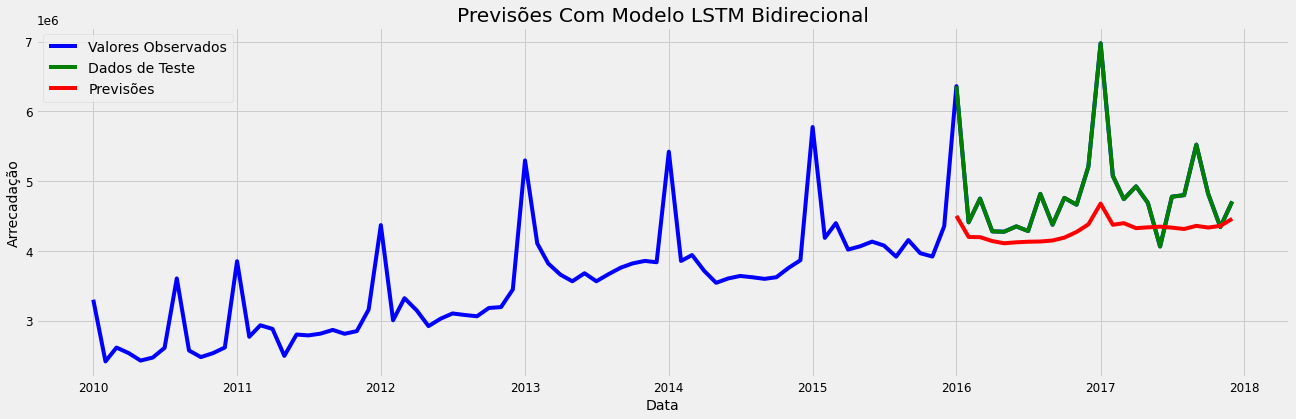

In [64]:
# Plot
plt.figure(figsize = (20, 6))

# Série original
plt.plot(target.index, target.values, label = 'Valores Observados', color = 'Blue')
plt.plot(teste, label = 'Dados de Teste', color = 'green')

# Previsões
plt.plot(teste.index, resultado_final, label = 'Previsões', color = 'Red')

plt.title('Previsões Com Modelo LSTM Bidirecional')
plt.xlabel('Data')
plt.ylabel('Arrecadação')
plt.legend(loc = 'upper left')
plt.show()

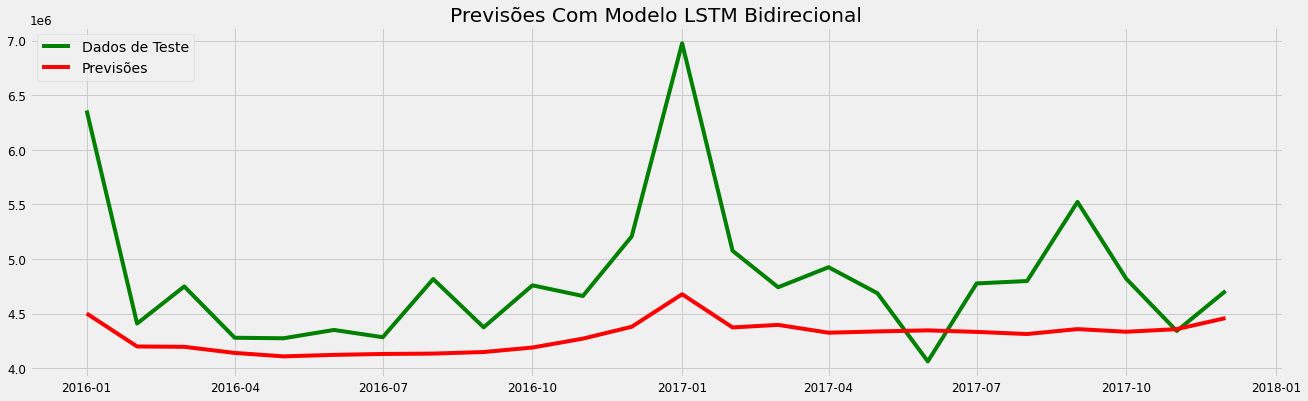

In [65]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(target[72:].index,  resultado_final, label = 'Previsões', color = 'Red')
plt.title('Previsões Com Modelo LSTM Bidirecional')
plt.legend(loc = 'upper left')
plt.show()

Vamos fazer o Forecasting para 24 meses de horizonte de previsão. A função DateOffset() vai nos ajudar a criar as datas.

Vejamos qual é a última data da nossa série original:

In [66]:
# Última data da série
target.index[-1]

Timestamp('2017-12-01 00:00:00')

In [78]:
# Cria sequência de datas a partir da última data da nossa série original
datas_para_prever_forecasting = [target.index[-1] + DateOffset(months = x) 
                                 for x in range(0, 25)]

In [79]:
# Visualiza as datas criadas
#datas_para_prever_forecasting

In [80]:
# Nossa série original é um objeto do tipo pd.Series
#type(target)

In [81]:
# Objetos do tipo pd.Series dão mais trabalho para manipular. Vamos converter a série original em dataframe.
df_original = pd.DataFrame(target)

In [82]:
# Visualiza os dados
#df_original.head()

In [83]:
# Vamos agora criar um novo dataframe 
# O índice (data) será a sequência de datas futuras
# O nome da coluna de dados extraímos da série original
# ATENÇÃO: Não estamos extraindo os dados da série original, somente o nome da coluna
data_futuras = pd.DataFrame(index = datas_para_prever_forecasting[1:], columns = df_original.columns)

In [84]:
# Visualiza os dados
# Entendeu por que os valores NaN? São datas futuras, e precisamos agora incluir nossas previsões.
#data_futuras

In [85]:
# Usamos as datas futuras para extrair as previsões do nosso modelo
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index = data_futuras[-n_input:].index, columns = ['Prediction'])

In [86]:
# Concatenamos a série original com os valores de forecasting de 24 meses além da série
df_forecasting = pd.concat([df_original, df_predict], axis = 1)

In [87]:
# Visualiza o dataframe
#df_forecasting

### Previsão x Forecasting

Esse dataframe acima é para não restar qualquer dúvida do que estamos fazendo.

Nas **previsões** do modelo, usamos os dados de teste, 24 meses que correspondem aos 24 últimos registros da série original (2016-01-01 a 2017-12-01. Fazemos isso para poder calcular a precisão do modelo, comparando as previsões com os valores reais. Esse é o padrão em Machine Learning.

No **forecasting**, criamos 24 meses após a última data da série original. Obviamente, não temos dados históricos para esses meses e o que queremos é exatamente a previsão de vendas. O forecasting significa usar o modelo treinado e prever valores sobre novas datas.

Bingo!

Vamos colocar o forecasting em um Plot.

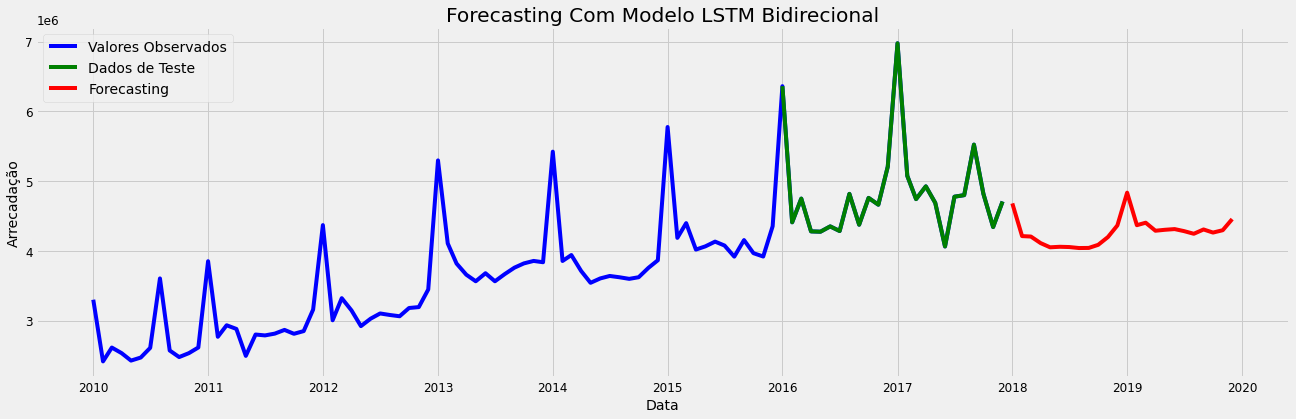

In [89]:
# Plot
plt.figure(figsize = (20, 6))

# Série original
plt.plot(target.index, target.values, label = 'Valores Observados', color = 'Blue')
plt.plot(teste, label = 'Dados de Teste', color = 'green')

# Previsões
plt.plot(df_forecasting.index, df_forecasting['Prediction'], label = 'Forecasting',  color = 'Red')

plt.title('Forecasting Com Modelo LSTM Bidirecional')
plt.xlabel('Data')
plt.ylabel('Arrecadação')
plt.legend(loc = 'upper left')
plt.show()

E aí está nosso modelo de Deep Learning para previsão de séries temporais! Conseguimos colocar essa versão do modelo entre o Top5 dos modelos que criamos até aqui. Mas dada a natureza da série que estamos usando, o Prophet foi imbatível.

Se treinarmos o modelo acima por um período maior, talvez tenhamos um resultado ainda mais interessante. Você pode tentar isso se desejar.

Resumindo o que fizemos nesta aula:
    
- Removemos os picos de vendas da série original.
- Criamos a primeira versão do modelo LSTM Bidirectional (que teve boa performance).
- Executamos o Grid Search para buscar os melhores hiperparâmetros.
- Criamos a versão final do modelo com os melhores hiperparâmetros.

Como estamos até agora:
    
- Modelo 15 --> Modelo ARMA (12,9) - AIC = 2044.48 e RMSE = 706415.3914
- Modelo 16 --> Modelo ARIMA (2,1,1) - AIC = 2106,43 e RMSE = 1099391.3958
- Modelo 17 --> Modelo SARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC = 1251.06 e RMSE = 332666.2626
- Modelo 18 --> Modelo SARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC = 1233.47 e RMSE = 336782.4202
- Modelo 22 --> Modelo LSTM Padrão - MAPE = 15.8048 e RMSE = 1037107.0089   -   (5 repetições)
- Modelo 22 --> Modelo LSTM Padrão - MAPE = 11.7861 e RMSE = 878868.4191   -   (20 repetições)
- Modelo 23 --> Modelo Stacked LSTM - MAPE = 13.1198 e RMSE = 945778.1667
- Modelo 24 --> Modelo Stacked LSTM Profundo - MAPE = 12.3914 e RMSE = 877490.6632 
- Modelo 25 --> Modelo Bidirectional LSTM - MAPE = 10.7944 e RMSE = 850832.6951


Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim